In [29]:
import multiagent
multiagent.__file__

'/data/akvasov/multiagent-particle-envs_shariqiqbal2810/multiagent/__init__.py'

In [30]:
def render_games(numAgents, episode_length, pid, queue, env, agentModels, custom_reward,
                    mean_action, render, running_state, episodes):
    torch.randn(pid)
    log = dict()
    log['reward_list'] = []
    memory = [Memory() for _ in range(numAgents)]
    num_steps = 0
    total_reward = [0 for _ in range(numAgents)]
    min_reward = [1e6 for _ in range(numAgents)]
    max_reward = [-1e6 for _ in range(numAgents)]
    total_c_reward = [0 for _ in range(numAgents)]
    min_c_reward = [1e6 for _ in range(numAgents)]
    max_c_reward = [-1e6 for _ in range(numAgents)]
    num_episodes = 0
    # tbd, should match build main dtype
    dtype = torch.float

    for i in range(episodes):
        state = env.reset()
        reward_episode = []

        for t in range(episode_length):
            #print('t:{:.1f}\tnum_steps:{:.1f}\tmin_batch_size:{:.1f}'.format(t,num_steps,min_batch_size))
            # tbd, add .to(dtype)
            torch_obs = [tensor(st).to(dtype).unsqueeze(0) for st in state]

            with torch.no_grad():
                torch_action = agentModels.step(torch_obs, explore=True)
                action = [ac.data.numpy()[0] for ac in torch_action]
            next_state, reward, done, _ = env.step(action)
            reward_episode.append(reward)
            
            
            if custom_reward is not None:
                reward = custom_reward.expert_reward(state, action)
                total_c_reward = [sum(x) for x in zip(total_c_reward, reward)]
                min_c_reward = [min(x) for x in zip(min_c_reward, reward)]
                max_c_reward = [max(x) for x in zip(max_c_reward, reward)]

            for ai in range(numAgents):
                memory[ai].push(state[ai], action[ai], reward[ai], next_state[ai], done[ai])

            if render:
                show_state(env, step=t, info="")
                #env.render()
            #if done:
            #    break
            state = next_state

        # log stats
        num_steps += (t + 1)
        num_episodes += 1
        total_reward = [sum(x) for x in zip(total_reward, map(lambda x: sum(x), reward_episode))]
        min_reward = [min(x) for x in zip(min_reward, map(lambda x: sum(x), reward_episode))]
        max_reward = [max(x) for x in zip(max_reward, map(lambda x: sum(x), reward_episode))]
        log['reward_list'].append(reward_episode)

    log['num_steps'] = num_steps
    log['num_episodes'] = num_episodes
    log['total_reward'] = total_reward
    log['avg_reward'] = [tr/num_episodes for tr in total_reward] # tbd: num_episodes -> num_steps
    log['max_reward'] = max_reward
    log['min_reward'] = min_reward
    if custom_reward is not None:
        log['total_c_reward'] = total_c_reward
        log['avg_c_reward'] = [tr/num_steps for tr in total_c_reward]
        log['max_c_reward'] = max_c_reward
        log['min_c_reward'] = min_c_reward

    if queue is not None:
        queue.put([pid, memory, log])
    else:
        return memory, log

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from matplotlib.animation import FuncAnimation
from IPython.display import Video
plt.style.use('seaborn-pastel')
from matplotlib import pyplot as plt
%matplotlib inline

In [45]:
import torch
import os
import gym
import gym_foo
import errno
import sys
import pickle
import time
import json
import numpy as np
import pandas as pd
#from xvfbwrapper import Xvfb
#%matplotlib inline
import sys
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

proj_direc = '/data/akvasov/bm3il'
sys.path.append(os.path.abspath(os.path.join(
    proj_direc,'buildILGymEnvsRT', '..')))

from utils import *
from core.maagentMAACGymEnvs import AgentsInteraction
from algorithms.attention_sac import AttentionSAC
from utils.make_env import make_env
from utils.env_wrappers import StandardEnv
from utils.replay_memory_MAACGymEnvs import Memory

time_str = "06_08_2021_14:12:59"#'05_08_2021_22:50:24'#'06_07_2021_14:06:55'#'05_07_2021_21:34:34'#'03_07_2021_23:52:32'#'30_06_2021_00:40:39'#'06_06_2021_06:00:24'#'21_05_2021_12:23:14'#diverse_spread_v2 '20_05_2021_13:20:52'#diverse_spread_v2 '19_05_2021_23:44:48'#diverse_spread_v1 '16_05_2021_22:11:44'# simple_spread '16_05_2021_22:16:36'
iter_str = '4999'#'5999'#'999'#'5999'#'699'#'2899'# diverse_spread_v2 '3299'#diverse_spread_v2 '3799'#diverse_spread_v1 '3699'# simple_spread '5899'
maac_best = False
class ARGS():
    def __init__(self):
        # hyper-parameters for MAAC
        self.pol_hidden_dim = 128
        self.critic_hidden_dim = 128
        self.attend_heads = 4
        self.pi_lr = 1e-3 #1e-3
        self.q_lr = 1e-3 #1e-3
        self.tau = 1e-3 #1e-3
        self.gamma = 0.99
        self.reward_scale = 100
        self.episode_length = 25 #100, 25
        # hyper-parameters for IL
        self.render = False #False
        self.log_interval = 1
        self.gpu_index = 1
        self.seed = np.int(time.time())
        self.env_name = 'simple_spread_with_collab'#'multi_speaker_listener'#'simple_spread' #'simple_spread' # 'fullobs_collect_treasure', 'multi_speaker_listener'
        # hyper-parameters to be tuned for only collecting exeprt trajectories
        self.reset_memory_interval = 10
        self.min_batch_size = 800 #4000
        self.sample_size = 800 # number of samples for an update
        self.num_threads = 8 #4
        self.generator_epochs = 10
        self.max_iter_num = 6000 #1500 #30 #500 #6000
        self.load_checkpoint = True
        self.save_checkpoint_interval = 100
        self.expert_traj_len = int(2e4) #5e4
        self.collect_expert_samples = 1600 #int(1e3)
        # save directories
        dt_string = time_str#datetime.now().strftime("%d_%m_%Y_%H:%M:%S")
        self.exper_path = os.path.join(proj_direc, "buildILGymEnvsRT/data", self.env_name, "collect_samples", dt_string)
        self.description = 'vanilaMAAC'
        self.checkpoint_path = os.path.join(self.exper_path, "checkpoint_" + self.description)
        self.expert_traj_path = os.path.join(self.exper_path, "exp_traj2" + ".pkl")
        self.load_checkpoint_path=self.checkpoint_path.split('.pkl')[0] + '_iter' + iter_str  + '.tar'
        self.save_data_path = os.path.join(self.exper_path, self.env_name + "_vanilaMAAC.pkl")
        self.save_or_not = False
        

        
        
args = ARGS()
if maac_best:
    args.load_checkpoint_path = '/data/akvasov/MAAC/models/' + args.env_name+ '/maac_def/run1/incremental/model_ep49009.pt' #"multi_speaker_listener"

dtype = torch.float
torch.set_default_dtype(dtype)
cuda = True if torch.cuda.is_available() else False
#device = torch.device('cuda', index=args.gpu_index) if cuda else torch.device('cpu')
device = torch.device('cpu')
if cuda:
    torch.cuda.set_device(args.gpu_index)
"""environment"""
from gym import wrappers

rawEnv = make_env(args.env_name, discrete_action=True)
#rawEnv = wrappers.Monitor(rawEnv, "./gym-renders", force=True, mode="evaluation") 
env = StandardEnv(rawEnv)
numAgents = len(env.observation_space)
#state_dim = env.observation_space[0].shape[0]
#is_disc_action = len(env.action_space[0].shape) == 0
#action_dim = env.action_space[0].n if is_disc_action else env.action_space.shape[0]
"""seeding"""
np.random.seed(args.seed)
torch.manual_seed(args.seed)
env.seed(args.seed)
"""create save directory"""
try:
    os.makedirs(os.path.abspath(os.path.join(args.expert_traj_path,'..')), exist_ok=True)
    if args.save_or_not:
        os.makedirs(args.exper_path, exist_ok=True)
        os.makedirs(os.path.join(args.exper_path, "logs"), exist_ok=True)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
"""redirecting output"""
writer = None
if args.save_or_not:
    sys.stdout = open(os.path.join(args.exper_path, "logs", "log.txt"), 'w')
    writer = SummaryWriter(os.path.join(args.exper_path, "logs"))
        


<ipython-input-45-4c97edb83116>:48: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.seed = np.int(time.time())


In [46]:
n_episodes = 10

# agentModels = AttentionSAC.init_from_env(env,
#                                        tau=args.tau,
#                                        pi_lr=args.pi_lr,
#                                        q_lr=args.q_lr,
#                                        gamma=args.gamma,
#                                        pol_hidden_dim=args.pol_hidden_dim,
#                                        critic_hidden_dim=args.critic_hidden_dim,
#                                        attend_heads=args.attend_heads,
#                                        reward_scale=args.reward_scale)
if args.load_checkpoint:
    agentModels = AttentionSAC.init_from_save(args.load_checkpoint_path, load_critic=True,  device=device)
    print(args.load_checkpoint_path)
agentModels.prep_rollouts(device='cpu')
agentsInteract = AgentsInteraction(env, numAgents, agentModels, device, render=args.render, num_threads=args.num_threads)

/data/akvasov/bm3il/buildILGymEnvsRT/data/simple_spread_with_collab/collect_samples/06_08_2021_14:12:59/checkpoint_vanilaMAAC_iter4999.tar


In [47]:
memory, log = render_games(numAgents, args.episode_length, 0, None, agentsInteract.env, agentModels, agentsInteract.custom_reward, agentsInteract.mean_action,
                                      agentsInteract.render, agentsInteract.running_state, episodes=n_episodes)

## 1. Env render: simple_spread

In [48]:
np.array(log['reward_list'][i])

array([[ -7.7564529 ,  -7.7564529 ,  -7.7564529 ],
       [ -8.38358979,  -8.38358979,  -8.38358979],
       [ -9.26477744,  -9.26477744,  -9.26477744],
       [-10.35970818, -10.35970818, -10.35970818],
       [-12.99640591, -12.99640591, -12.99640591],
       [-10.56815476, -10.56815476, -10.56815476],
       [ -9.90334001,  -9.90334001,  -9.90334001],
       [ -9.01624727,  -9.01624727,  -9.01624727],
       [ -7.95827512,  -7.95827512,  -7.95827512],
       [ -7.01317228,  -7.01317228,  -7.01317228],
       [ -6.24540004,  -6.24540004,  -6.24540004],
       [ -5.76872864,  -5.76872864,  -5.76872864],
       [ -5.36285359,  -5.36285359,  -5.36285359],
       [ -5.28717954,  -5.28717954,  -5.28717954],
       [ -5.20942898,  -5.20942898,  -5.20942898],
       [ -4.79869598,  -4.79869598,  -4.79869598],
       [ -4.58862164,  -4.58862164,  -4.58862164],
       [ -4.6127334 ,  -4.6127334 ,  -4.6127334 ],
       [ -4.70004557,  -4.70004557,  -4.70004557],
       [ -4.70714827,  -4.70714

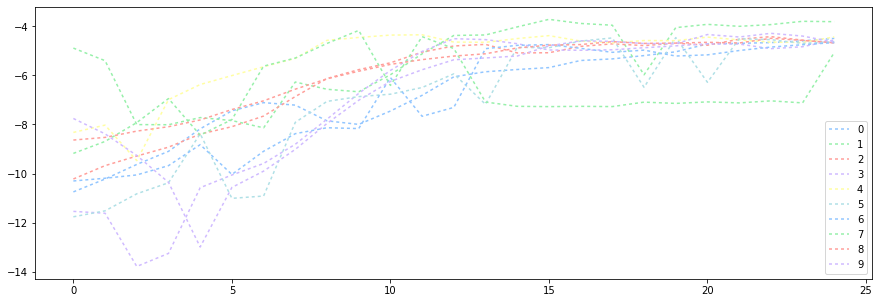

In [49]:
plt.figure(figsize=(15, 5))

for i in range(10):
    plt.plot(np.mean(np.array(log['reward_list'][i]), axis=1), label=str(i), dashes=[2, 2], alpha=1)
plt.legend()
plt.show()

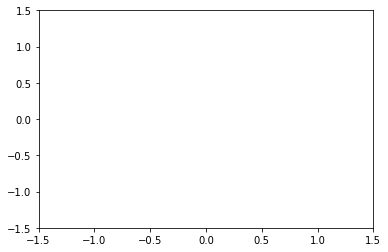

In [50]:
fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)
ax = plt.axes()
limits = 1.5
ax.set_xlim(-limits, limits)
ax.set_ylim(-limits, limits)

labels_lst = ['l1','l2','l3', 'a1','a2','a3']
colors_lst = ['grey','grey','grey','r','g','b']
size_list = [0.05, 0.05, 0.05, 0.15, 0.15, 0.15]
size_scale = 1000
size_list = [sl*size_scale for sl in size_list]
colors = dict(zip(labels_lst, colors_lst))
sizes_dict = dict(zip(labels_lst, size_list))

scats = []
data_memory = []
groups = dict(zip(labels_lst, [[memory[0].memory[ts].state[pts] + memory[0].memory[ts].state[[2, 3]] 
                                for ts in range(len(memory[0].memory))] 
                                for pts in [[4, 5], [6, 7], [8, 9]]]+[[memory[i].memory[ts].state[[2, 3]] for ts in range(len(memory[i].memory))]
                                                                      for i in range (numAgents)]))

In [52]:
for name in groups:
    scat = ax.scatter([], [],
                      color=colors[name],
                      label=name)
    scats.append(scat)
ax.legend(loc=4)


def init():
    for scat in scats:
        scat.set_offsets(np.array([[None, None]]))
    return scats,

def update(ts):
 
    for scat, name in zip(scats, groups):
        data = np.array(groups[name][ts])
        scat.set_offsets(data)
        scat.set_sizes([sizes_dict[name]])
    ax.set_title(args.env_name+' '+time_str+' '+iter_str + " episode {:.2f}".format(ts/args.episode_length))
    return scats,

anim = FuncAnimation(fig, update, init_func=init, #fargs=(ax),
                               frames=len(memory[0].memory), interval=50)

#                              repeat=True, blit=True)
videofile_name = os.path.join('./gym-renders', args.env_name+'_'+time_str+'_'+iter_str+'.mp4')
if maac_best:
    videofile_name = os.path.join('./gym-renders', "_".join(args.load_checkpoint_path.split('.')[0].split('models')[1].split('/')[1:]) + '.mp4')
print(videofile_name)
anim.save(videofile_name, writer='ffmpeg')
print("Done")

./gym-renders/simple_spread_with_collab_06_08_2021_14:12:59_4999.mp4
Done


In [53]:
#time_str = time_str #'30_06_2021_00:40:39'#'06_06_2021_06:00:24'#'21_05_2021_12:23:14'#diverse_spread_v2 '20_05_2021_13:20:52'#diverse_spread_v2 '19_05_2021_23:44:48'#diverse_spread_v1 '16_05_2021_22:11:44'# simple_spread '16_05_2021_22:16:36'
#iter_str = iter_str #'5999'#'699'#'2899'# diverse_spread_v2 '3299'#diverse_spread_v2 '3799'#diverse_spread_v1 '3699'# simple_spread '5899'

#videofile_name = os.path.join('./gym-renders', args.env_name+'_'+time_str+'_'+iter_str+'.mp4')
Video(videofile_name)

## 2. Env render: multi speaker lister

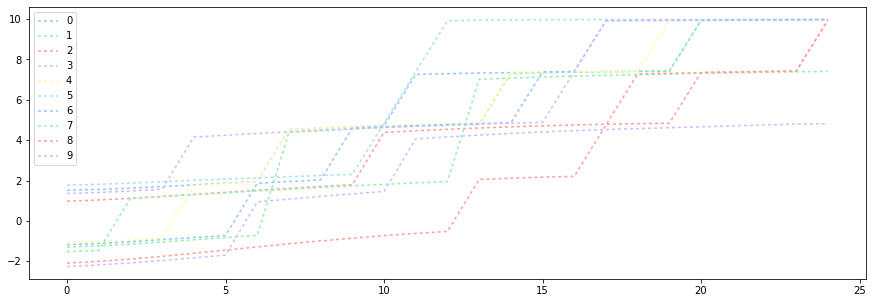

In [41]:
plt.figure(figsize=(15, 5))

for i in range(10):
    plt.plot(np.mean(np.array(log['reward_list'][i]), axis=1), label=str(i), dashes=[2, 2], alpha=1)
plt.legend()
plt.show()

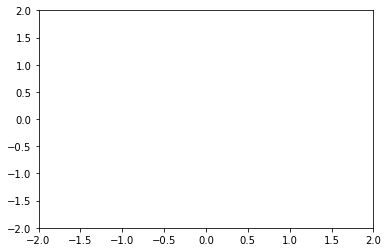

In [42]:
fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)
ax = plt.axes()
limits = 2
ax.set_xlim(-limits, limits)
ax.set_ylim(-limits, limits)

labels_lst = ['l1','l2','l3', 'l4', 'a1','a2','a3', 'a4']
colors_lst = ['grey','grey','grey', 'grey', 'r','g','b', 'k']
size_list = [0.05, 0.05, 0.05, 0.05, 0.15, 0.15, 0.15, 0.15]
size_scale = 1000
size_list = [sl*size_scale for sl in size_list]
colors = dict(zip(labels_lst, colors_lst))
sizes_dict = dict(zip(labels_lst, size_list))

scats = []
data_memory = []
groups = dict(zip(labels_lst, [[memory[i].memory[ts].state[[-2, -1]] 
                                for ts in range(len(memory[i].memory))]
                                for i in range (4, 4+4)] + 
                              [[memory[i].memory[ts].state[[-4, -3]] 
                                for ts in range(len(memory[i].memory))]
                                for i in range (4, 4+4)]))

In [8]:
for name in groups:
    scat = ax.scatter([], [],
                      color=colors[name],
                      label=name)
    scats.append(scat)
ax.legend(loc=4)


def init():
    for scat in scats:
        scat.set_offsets(np.array([[None, None]]))
    return scats,

def update(ts):
 
    for scat, name in zip(scats, groups):
        data = np.array(groups[name][ts])
        scat.set_offsets(data)
        scat.set_sizes([sizes_dict[name]])
    ax.set_title(args.env_name+' '+time_str+' '+iter_str + " episode {:.2f}".format(ts/args.episode_length))
    return scats,

anim = FuncAnimation(fig, update, init_func=init, #fargs=(ax),
                               frames=len(memory[0].memory), interval=50)

#                              repeat=True, blit=True)
videofile_name = os.path.join('./gym-renders', args.env_name+'_'+time_str+'_'+iter_str+'.mp4')
videofile_name = os.path.join('./gym-renders', "_".join(args.load_checkpoint_path.split('.')[0].split('models')[1].split('/')[1:]) + '.mp4')
print(videofile_name)
anim.save(videofile_name, writer='ffmpeg')
print("Done")

./gym-renders/multi_speaker_listener_maac_def_run1_incremental_model_ep49009.mp4
Done


In [81]:
#time_str = time_str #'30_06_2021_00:40:39'#'06_06_2021_06:00:24'#'21_05_2021_12:23:14'#diverse_spread_v2 '20_05_2021_13:20:52'#diverse_spread_v2 '19_05_2021_23:44:48'#diverse_spread_v1 '16_05_2021_22:11:44'# simple_spread '16_05_2021_22:16:36'
#iter_str = iter_str #'5999'#'699'#'2899'# diverse_spread_v2 '3299'#diverse_spread_v2 '3799'#diverse_spread_v1 '3699'# simple_spread '5899'

#videofile_name = os.path.join('./gym-renders', args.env_name+'_'+time_str+'_'+iter_str+'.mp4')
Video(videofile_name)

In [112]:
import gym
from gym import wrappers
from utils.make_env import make_env

env = gym.make('SpaceInvaders-v0')
#env = make_env('simple_spread')
env = wrappers.Monitor(env, "./gym-renders", force=True)
env.reset()
for _ in range(3000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done: break
env.close()

In the meantime you can manually solve it by going to gym/wrappers/monitoring/video_recorder.py
and de-indent by une step the function call self.proc.stdin.write(frame.tobytes())
meaning that it does not have to be nested under any if statement.

In [2]:
from IPython.display import Video

Video('./gym-renders/openaigym.video.%s.video000000.mp4' % env.file_infix)

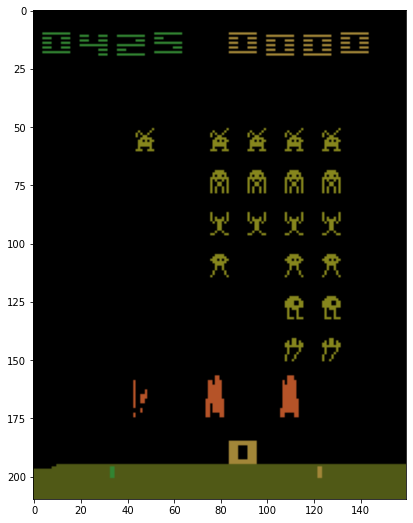

In [8]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('SpaceInvaders-v0')
env.reset()
plt.figure(figsize=(9,9))
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(1000):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)
env.close()